En este laboratorio vamos a utilizar el conjunto de datos compuesto por imágenes de dígitos manuscritos de MNIST.

Primero vamos a ver una muestra de estas imágenes:

100%|██████████| 9.91M/9.91M [00:00<00:00, 15.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 479kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.38MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.10MB/s]


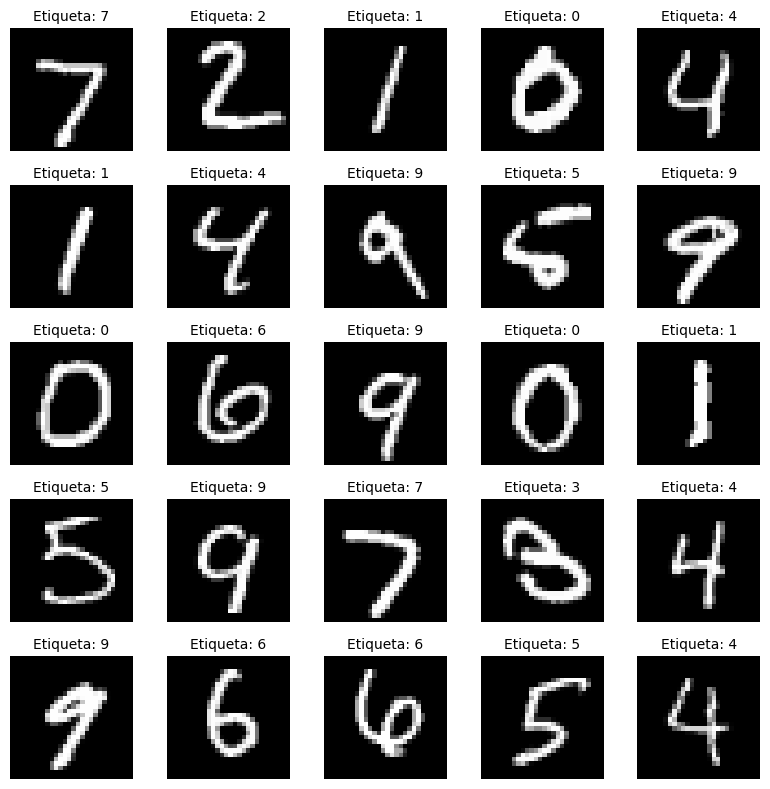

In [2]:
# Empezamos importando las librerías necesarias
import matplotlib.pyplot as plt # para mostrar las imágenes
import torchvision # utilidades para visión artificial
import torchvision.transforms as transforms # para convertir imágenes en tensores
from torchvision.datasets import MNIST # dataset de dígitos manuscritos
import torch # librería para redes neuronales, PyTorch

# Transformación para convertir a tensor
transform = transforms.ToTensor()

# Descargamos el conjunto de prueba (test)
test_set = MNIST(root='./data', train=False, download=True, transform=transform)

# Vemos una muestra de 25 imágenes
def show_mnist_samples(dataset, num_images=25):
    plt.figure(figsize=(8, 8))
    for i in range(num_images):
        image, label = dataset[i]
        image = image.squeeze().numpy()  # Convertir a 2D
        plt.subplot(5, 5, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Etiqueta: {label}", fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Mostramos las imágenes
show_mnist_samples(test_set)


Y ahora pasamos a entrenar el modelo, una red neuronal simple, y a llevar a cabo el ataque FGSM

Predicción original: 2 (correcta: 2)
🧨 Predicción adversaria: 3


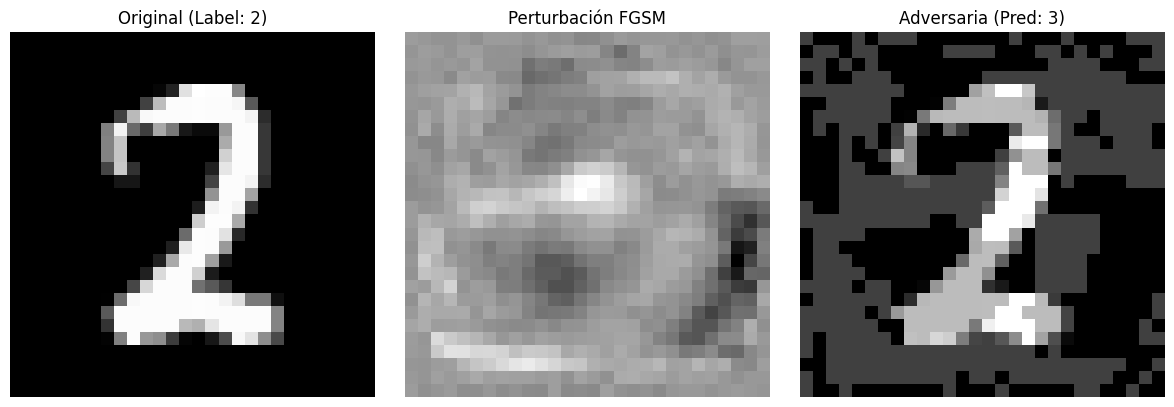

In [3]:
# Importamos otras librerías necesarias
import torch.nn as nn # para definir las redes neuronales
import torch.optim as optim # librería para usar algoritmos de entrenamiento como Adam.
import numpy as np # para hacer operaciones con matrices

# Datos MNIST
transform = transforms.ToTensor()
test_set = MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)

# Definimos una red neuronal sencilla con 4 capas
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.fc(x)

model = SimpleNN()

# Entrenamos un poco con datos reales
train_set = MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(1):  # Entrenamiento corto
    for images, labels in train_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Función de ataque FGSM
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    return torch.clamp(perturbed_image, 0, 1)

# Usamos una imagen real
data_iter = iter(test_loader)
image, label = next(data_iter)
image.requires_grad = True

# Predicción original
output = model(image)
init_pred = output.max(1, keepdim=True)[1]
print(f"Predicción original: {init_pred.item()} (correcta: {label.item()})")

# Calculamos gradiente de la pérdida
loss = criterion(output, label)
model.zero_grad()
loss.backward()
data_grad = image.grad.data

# Creamos imagen adversaria
epsilon = 0.25
perturbed_image = fgsm_attack(image, epsilon, data_grad)

# Predicción con imagen modificada
output_adv = model(perturbed_image)
final_pred = output_adv.max(1, keepdim=True)[1]
print(f"🧨 Predicción adversaria: {final_pred.item()}")

# Visualización
def show_image(img_tensor, title=""):
    img = img_tensor.squeeze().detach().numpy()
    plt.imshow(img, cmap="gray")
    plt.title(title)
    plt.axis("off")

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
show_image(image, title=f"Original (Label: {label.item()})")

plt.subplot(1, 3, 2)
show_image(epsilon * data_grad, title="Perturbación FGSM")

plt.subplot(1, 3, 3)
show_image(perturbed_image, title=f"Adversaria (Pred: {final_pred.item()})")

plt.tight_layout()
plt.show()
